In [1]:
#### Field Plots #####
import os
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import cm
import math
from scipy.stats import norm
import seaborn as sns
import xarray as xr
import netCDF4 as nc
import sys

sys.setrecursionlimit(100000)
###########################################################################################################################
def make_netcdffile_fromcross(time_start, time_end, time_gap, x_spacing, variable_name, path, output_name, del_files): 
    float_type = 'f4'
    time_ind_total = int((time_end-time_start)/time_gap) + 1
    time = np.linspace(time_start,time_end,time_ind_total)
    filename = path+variable_name + str(format(int(time[0]),'07d'))
    fid=open(filename,'rb')
    x_length = int(np.sqrt(len(np.fromfile(fid))))
    x=np.linspace(x_spacing,x_length*x_spacing,x_length)
    y=np.linspace(x_spacing,x_length*x_spacing,x_length)
    fid.close()
    if os.path.exists(path+output_name):
        os.remove(path+output_name)
    nc_file = nc.Dataset(path+output_name, mode="w", datamodel="NETCDF4", clobber=False)
    nc_file.createDimension("x", x_length)
    nc_file.createDimension("y", x_length)
    nc_file.createDimension("t", time_ind_total)
    nc_x = nc_file.createVariable("x", float_type, ("x"))
    nc_y = nc_file.createVariable("y", float_type, ("y"))
    nc_t = nc_file.createVariable("t", float_type, ("t"))
    var_name = variable_name.split('.')[0]
    locals()[var_name] = np.zeros((x_length,x_length,time_ind_total))
    locals()['nc_'+var_name] = nc_file.createVariable(var_name, float_type, ("x","y","t"))                    
    for i in range(0,time_ind_total):
        filename = path+variable_name+str(format(int(time[i]),'07d'))
        fid=open(filename,'rb')
        var = np.fromfile(fid)
        locals()[var_name][:,:,i]=np.reshape(var,[x_length,x_length])
        fid.close()
    locals()['nc_'+var_name][:] = locals()[var_name][:]




    nc_x [:] = x[:]
    nc_y [:] = y[:]
    nc_t [:] = time[:]
    nc_file.close()
    if del_files:
        #files = ["u", "v", "w", "thl", "time", "qr", "ql", "couv", "grid", "nr","qt","therm","bc"]
        files = [variable_name]
        for file in os.listdir(path):
            for i in range(0,len(files)):
                if file.find(files[i])!=-1: 
                    os.remove(path+file)
                #rm u* v* w* thl* time* qr* ql* couv* grid* nr* qt* therm* 
##########################################################################################
class cell:
    def __init__(self, id):
        self.id = id
        self.value = [[],[]]
        self.location = [[],[]]
        self.nelements = 0
        self.nelements_local = 0

    def add_elements(self, i, j, var_values):
        self.location[0].append(i)
        self.location[1].append(j)
        self.value[0].append(var_values)
        self.nelements = self.nelements + 1
        self.nelements_local = self.nelements_local + 1
    def __del__(self):
        return
##########################################################################################
def find_boolean(variable, threshold_criteria): #variable is f(i, j, t): --> outputs boolean -1 (unsatisfied) 0 (satisfied) 
    boolean = np.zeros(( len(variable[:,0]), len(variable[0,:])))
    boolean = -1
    boolean = np.where(variable[:,:]>threshold_criteria,0,-1)
    return boolean;
########################################################################################
def identify_elements_in_cell(i,j,new_cell):  #input the ijk at which boolean is satisfied along with boolean and new cell created 

    global booli;
    new_cell.add_elements(i,j,cell_variable[i,j])
    booli[i,j] = -1

    ii=i-1; jj=j; #look west
    if ii<0:
       ii = nx-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i+1; jj=j;  #look east
    if ii>nx-1:
       ii = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j+1;  #look north
    if jj>ny-1:
        jj = 0
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell)  

    ii=i; jj=j-1;  #look south
    if jj<0:
       jj = ny-1
    if (booli[ii,jj] == 0):
        identify_elements_in_cell(ii,jj,new_cell) 
#################################################################################################
def create_new_cell(variable,bool):                                # input the boolean and the variable, output is the cells tracked (i,j,t) based on boolean 
    cell_number = 0;
    global booli,cell_variable,nx,ny;
    nx = len(variable[:,0])
    ny = len(variable[0,:])
    booli=bool;cell_variable = variable;
    variable_cells = []
    for j in range(0,ny):
        for i in range(0,nx):
            if booli[i,j]==0: 
                new_cell=cell(cell_number) 
                identify_elements_in_cell(i,j,new_cell)
                if new_cell.nelements>=nminelems:
                    variable_cells.append(new_cell)
                    variable_cells[cell_number].id = cell_number
                    cell_number = cell_number + 1
                else:
                    del new_cell;
    return variable_cells, cell_number;
#################################################################################################
def run_tracking(tracked_variable,param_threshold):
    global nx,ny;
    nx = len(tracked_variable[:,0]); ny = len(tracked_variable[0,:]); 
    bool = find_boolean(tracked_variable,param_threshold)
    [cells,cell_number] = create_new_cell(tracked_variable,bool);
    return cells,cell_number;
####################################################################################################
def find_cell_centers(cells,ncells):
    centers=np.zeros((ncells,2))
    for i in range(0,ncells):
        centers[i,0]=np.mean(cells[i].location[0])
        centers[i,1]=np.mean(cells[i].location[1])
    return centers;
####################################################################################################
def find_nearest_neighbor(centers,nx,ny):
    distance=np.zeros(len(centers[:,0]))
    nn_distance=np.zeros(len(centers[:,0]))
    for i in range(len(centers[:,0])):
        for j in range(len(centers[:,0])):
            if i==j:
                distance[j]=100;
            else:
                xdist=min(abs(centers[i,0]+nx-centers[j,0]),abs(centers[i,0]-nx-centers[j,0]),abs(centers[i,0]-centers[j,0]))
                ydist=min(abs(centers[i,1]+ny-centers[j,1]),abs(centers[i,1]-ny-centers[j,1]),abs(centers[i,1]-centers[j,1]))
                distance[j]=math.sqrt(xdist**2+ydist**2)
        nn_distance[i]=min(distance)
    return nn_distance;
####################################################################################################
def retrieve_variable(variable_name,netcdf_path): #open corresponding netcdf file and read data
    all_data=xr.open_dataset(netcdf_path)
    var=all_data[variable_name].values
    variable=var
    x=all_data['x'].values
    y=all_data['y'].values
    t=all_data['t'].values
    return variable, x, y, t;    
##########################################################################################
#[w_cross,x,y,t]=retrieve_variable(variable_name='w',netcdf_path='/fs/ess/PFS0220/eurec4a/case_1060lagtraj_feb2_withw/w_cross.nc')
def get_iorg(variable,param_threshold,start_ind,stop_ind):
    i_org=np.zeros(len(variable[0,0,start_ind:stop_ind+1]))
    for i in range(0,stop_ind-start_ind+1):
        [updraft,ncells]=run_tracking(tracked_variable=variable[:,:,start_ind+i],param_threshold=param_threshold)
        if ncells<2:
            i_org[i]=0;
        else:
            centers=find_cell_centers(updraft,ncells)
            nn_distance=find_nearest_neighbor(centers,nx,ny)
            centers=centers.astype(int)
            nn_sorted = np.sort(nn_distance);nn_sorted=nn_sorted/max(nn_sorted)
            p = 1. * np.arange(len(nn_distance)) / (len(nn_distance) - 1)
            p_ran=1-np.exp(-1*(math.pi)*nn_sorted*nn_sorted)
            i_org[i]=np.trapz(p,x=p_ran)
        if i==0 and ncells>2:
            pl.figure()
            pl.contour(x/1000,y/1000,variable[:,:,start_ind+i]>1)
            pl.title('w > 1 ms$^-1$ at z = 800 m')
            pl.xlabel('X (km)')
            pl.ylabel('Y (km)')
            pl.show()
            
            pl.figure()
            center_arr=np.zeros((nx,ny))
            center_arr[(centers[:,0]),(centers[:,1])]=1;
            pl.contour(x/1000,y/1000,center_arr)
            pl.xlabel('x')
            pl.ylabel('y')
            pl.title('Centroids of Updrafts')

            pl.figure()
            pl.plot(nn_sorted,p,nn_sorted,p_ran)
            pl.xlabel('x (NN Distance)')
            pl.ylabel('p=F(x)')

            pl.figure()
            pl.plot(p_ran,p)
            pl.xlabel('Random CDF')
            pl.ylabel('NNCDF')            

        print(i)
    return i_org;
#########################################################################################

nc_path='/fs/ess/PFS0220/eurec4a/case_feb2nd_specific_final_100m_512/'
nc_path='/fs/ess/PFS0220/LSM/SGP/SGP_20170922/'
make_netcdffile_fromcross(time_start=0,time_end=2448,time_gap=9,x_spacing=40,variable_name='qlpath.xy.',path=nc_path,output_name='qlpath.nc',del_files=True)



In [43]:
#[qltop,x,y,t]=retrieve_variable(variable_name='qltop',netcdf_path=nc_path+'qltop.nc')
#[qlbase,x,y,t]=retrieve_variable(variable_name='qlbase',netcdf_path=nc_path+'qlbase.nc')
[qlpath,x,y,t]=retrieve_variable(variable_name='qlpath',netcdf_path=nc_path+'qlpath.nc')
nx=len(x);ny=len(y); start_ind=np.absolute(t-10*36).argmin(); stop_ind=np.absolute(t-82.75*36).argmin()
nminelems=2;
cloud_elems=np.zeros((stop_ind+1,524288))
#cloud_elems_3d=int(np.zeros((1)))
for i in range(0,stop_ind-start_ind+1):
    [cloud,ncells]=run_tracking(tracked_variable=qlpath[:,:,start_ind+i],param_threshold=0.01
                                )
    for j in range(0,ncells):
        cloud_elems[start_ind+i,j]=cloud[j].nelements
        #ii=cloud[j].location[0];jj=cloud[j].location[1];
        #cloud_elems_3d=np.append(cloud_elems_3d,[(cloud[j].nelements)*(qltop[ii,jj,start_ind+i]-qlbase[ii,jj,start_ind+i])])
#del qlpath,qlbase,qltop


Text(0, 0.5, 'Number of Clouds')

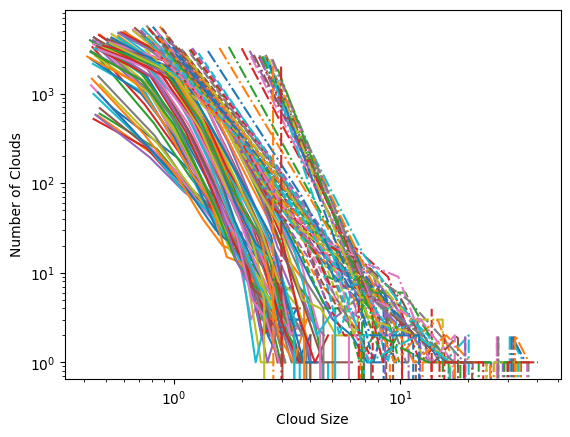

In [60]:


pl.figure()
bin_centers_mean=np.zeros((4,8))
for i in range(240,384):
    nz_indices=np.nonzero(cloud_elems[i,:])[0]
    y, bin_edges = np.histogram(np.sqrt(cloud_elems[i,nz_indices])*0.2,bins=8)
    #y, bin_edges = np.histogram((cloud_elems[i,nz_indices]),bins=8)
    bin_centers=0.5*(bin_edges[1:]+bin_edges[:-1])
    if i>320 and i<360:
        pl.plot(bin_centers,y,'--')
    elif i>=360 and i<384:
        pl.plot(bin_centers,y,'-.')
    elif i>=384:
        pl.plot(bin_centers,y,'k-')
    else:
        pl.plot(bin_centers,y)
#pl.hist(cloud_elems,bins=15)
#pl.xscale('log')
pl.yscale('log')
pl.xscale('log')
pl.xlabel('Cloud Size')
pl.ylabel('Number of Clouds')


#pl.figure()
#pl.hist(cloud_elems_3d,bins=15)
#pl.xscale('log')
#pl.yscale('log')
#pl.xlabel('3-D Cloud Size')
#pl.ylabel('Number of Cloud Cells')

Text(0.5, 1.0, 'Starting 31st Jan (512*512-200m)')

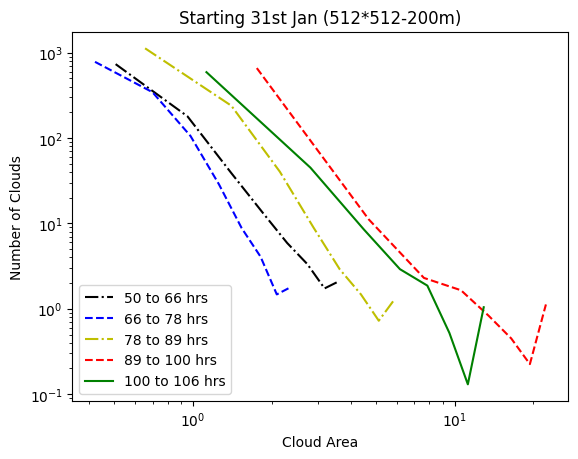

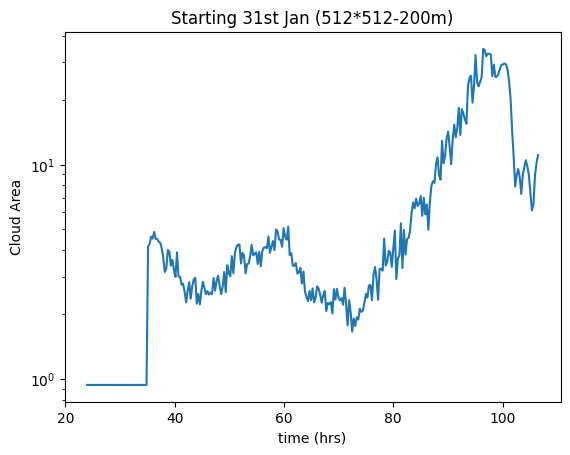

In [45]:


pl.figure()
nbins=8
t_end=297
t_start=86
bin_centers=np.zeros((t_end,nbins))
y_centers=np.zeros((t_end,nbins))
for i in range(0,t_end):
    nz_indices=np.nonzero(cloud_elems[i,:])[0]
    y, bin_edges = np.histogram(np.sqrt(cloud_elems[i,nz_indices])*0.2,bins=nbins)
    #y, bin_edges = np.histogram((cloud_elems[i,nz_indices]),bins=8)
    bin_centers[i,:]=0.5*(bin_edges[1:]+bin_edges[:-1])
    y_centers[i,:]=y
pl.plot(np.mean(bin_centers[180-t_start:240-t_start,:],axis=0),np.mean(y_centers[180-t_start:240-t_start,:],axis=0),'k-.',label='50 to 66 hrs')
pl.plot(np.mean(bin_centers[240-t_start:280-t_start,:],axis=0),np.mean(y_centers[240-t_start:280-t_start,:],axis=0),'b--',label='66 to 78 hrs')
pl.plot(np.mean(bin_centers[280-t_start:320-t_start,:],axis=0),np.mean(y_centers[280-t_start:320-t_start,:],axis=0),'y-.',label='78 to 89 hrs')
pl.plot(np.mean(bin_centers[320-t_start:360-t_start,:],axis=0),np.mean(y_centers[320-t_start:360-t_start,:],axis=0),'r--',label='89 to 100 hrs')
pl.plot(np.mean(bin_centers[360-t_start:384-t_start,:],axis=0),np.mean(y_centers[360-t_start:384-t_start,:],axis=0),'g-',label='100 to 106 hrs')
#pl.hist(cloud_elems,bins=15)
#pl.xscale('log')
pl.yscale('log')
pl.xscale('log')
pl.xlabel('Cloud Area')
pl.ylabel('Number of Clouds')
pl.title('Starting 31st Jan (512*512-200m)')
pl.legend(loc="lower left")

t_start=86.4
time=np.linspace(t_start/3.6,(t_end+t_start)/3.6,(t_end))
pl.figure()
#for i in range(0,nbins):
#    pl.plot(bin_centers[:,i])
pl.plot(time,bin_centers[:,nbins-1])
pl.yscale('log')
pl.xlabel('time (hrs)')
pl.ylabel('Cloud Area')
pl.title('Starting 31st Jan (512*512-200m)')
#pl.figure()
#pl.hist(cloud_elems_3d,bins=15)
#pl.xscale('log')
#pl.yscale('log')
#pl.xlabel('3-D Cloud Size')
#pl.ylabel('Number of Cloud Cells')

In [ ]:
i_org1=get_iorg(variable=w_cross1,param_threshold=1,start_ind=,stop_ind=np.absolute(t-hr2*36).argmin())
tt=t[start_ind:stop_ind+1]

[w_cross2,x,y,t]=retrieve_variable(variable_name='w',netcdf_path=nc_path+'w_cross2.nc')
nx=len(x);ny=len(y); start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
nminelems=2; #t3=t[start_ind:stop_ind+1]
i_org2=get_iorg(variable=w_cross2,param_threshold=1,start_ind=start_ind,stop_ind=stop_ind)

[couv_cross1,x,y,t]=retrieve_variable(variable_name='couvreux',netcdf_path=nc_path+'couvreux_cross1.nc')
start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
i_org3=get_iorg(variable=couv_cross1,param_threshold=1e-5,start_ind=start_ind,stop_ind=stop_ind)
#[max_ql,ql_cell]=get_maxelems(variable=qlpath,param_threshold=0.01,start_ind=start_ind,stop_ind=stop_ind)

[couv_cross2,x,y,t]=retrieve_variable(variable_name='couvreux',netcdf_path=nc_path+'couvreux_cross2.nc')
start_ind=np.nonzero(t==0)[0][0]; stop_ind=np.nonzero(t==3456)[0][0]
i_org4=get_iorg(variable=couv_cross2,param_threshold=1e-5,start_ind=start_ind,stop_ind=stop_ind)

#[qrpath,x,y,t]=retrieve_variable(variable_name='qrpath',netcdf_path=nc_path+'qrpath.nc')
#[max_qr,qr_cell]=get_maxelems(variable=qrpath,param_threshold=1e-4,start_ind=start_ind,stop_ind=stop_ind)

#[qrfluxbot,x,y,t]=retrieve_variable(variable_name='qrfluxbot',netcdf_path=nc_path+'qrfluxbot.nc')
#i_org=np.concatenate((i_org1,i_org2,i_org3))
#t_all=np.concatenate((t1,t2,t3))

#fig,ax=pl.subplots()
#pl.plot(t_all*100/3600,i_org)
#ax.plot(t3*100/3600,max_ql,'b-',t3*100/3600,max_qr,'r--')
#ax.set_xlabel('Time (in Hours)')
#ax.set_ylabel('Max_elelms')
#pl.yscale('log')
#ax2=ax.twinx()
#ax2.plot(t3*100/3600,i_org3,'g.-')
#ax2.set_ylabel('i_org')

#fig,ax=pl.subplots()
#ax.plot(t3*100/3600,ql_cell,'b-')
#ax.set_xlabel('Time (in Hours)')
#ax.set_ylabel('ql sum over Max Cell')
#pl.yscale('log')
#ax2=ax.twinx()
#ax2.plot(t3*100/3600,qr_cell,'r--')
#ax2.set_ylabel('qr sum over Max Cell')
#pl.yscale('log')
#hrs=80.25
#pl.figure()
#pl.contour(x,y,qlpath[:,:,int(hrs/100*3600)])

fig,ax=pl.subplots()
ax.plot(tt*100/3600,i_org1,'b-',tt*100/3600,i_org2,'r--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('iorg')

fig,ax=pl.subplots()
ax.plot(tt*100/3600,i_org3,'b-',tt*100/3600,i_org4,'r--')
ax.set_xlabel('Time (in Hours)')
ax.set_ylabel('iorg')